In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

df = pd.read_csv("gld_price_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

dates = df['Date'].values
data = df[['GLD']].values

In [111]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [112]:
# Tạo chuỗi đầu vào cho mô hình GRU
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Cắt dữ liệu train/test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Tạo mảng ngày tương ứng với tập train/test
train_dates = df['Date'][seq_length:seq_length+split].reset_index(drop=True)
test_dates = df['Date'][seq_length+split:].reset_index(drop=True)

In [113]:
# Xây mô hình GRU
model = Sequential()
model.add(GRU(64, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\admin\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [114]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0598
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.9695e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1581e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5449e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.5966e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.5953e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.4271e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0299e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1900e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7320e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.7590e-04
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 2.9292e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 2.9800e-04
Epoch 15/20
56/56 ━━━━━

In [115]:
# Tính toán các độ đo
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)
train_inv = scaler.inverse_transform(y_train)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2 Score:", r2)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
MAE: 0.8412667895792464
MAPE: 0.6935469131257473
RMSE: 1.1134040131976148
R2 Score: 0.9481466988501777


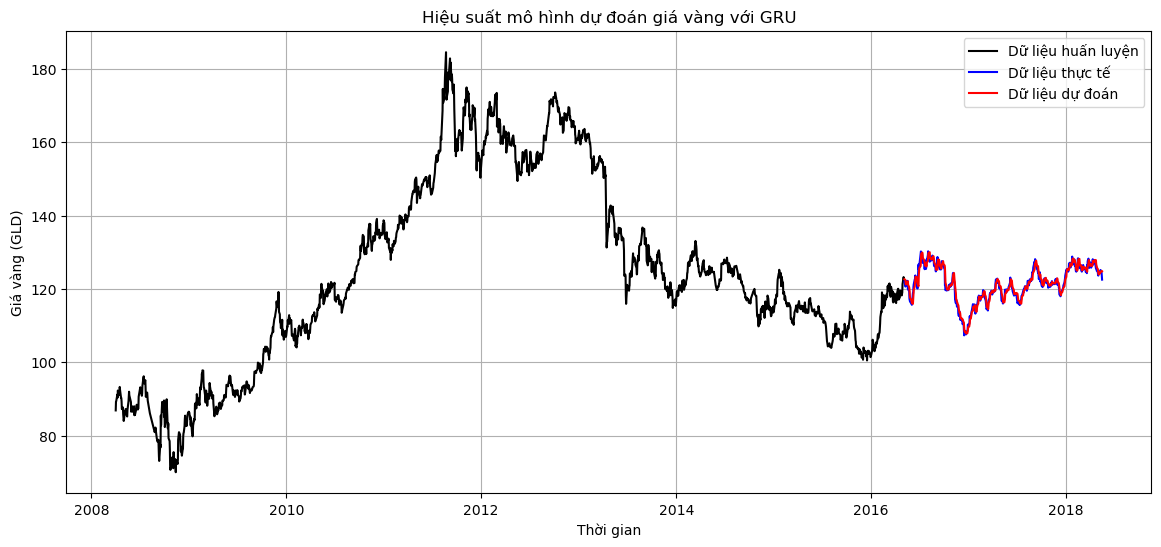

In [ ]:
# Vẽ biểu đồ
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_inv, label='Dữ liệu huấn luyện', color='black')
plt.plot(test_dates, y_test_inv, label='Dữ liệu thực tế', color='blue')
plt.plot(test_dates, y_pred_inv, label='Dữ liệu dự đoán', color='red')
plt.title('Hiệu suất mô hình dự đoán giá vàng với GRU')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng (GLD)')
plt.legend()
plt.grid()

years = pd.to_datetime([f'{y}-01-01' for y in range(2008, 2020, 2)])
plt.xticks(ticks=years, labels=[str(y.year) for y in years])

plt.show()